In [1]:
# import
import pandas as pd
import numpy as np
import glob
import warnings
warnings.filterwarnings('ignore')
#import matplotlib.pyplot as plt
import itertools
import numpy as np
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
# Machine Learning libraries.
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest,f_classif

In [2]:
k=15

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    


def Classifier_performance(clf, target_names, y, filledData, X_train, X_test, y_train, y_test, title="confusion matrix"):
    # Fitting the training data
    clf.fit(X_train, y_train)
    
    # Predicting the data
    y_pred = clf.predict(X_test)
    Y_train_pred = clf.predict(X_train)
    
    # Printing the accuracies and confusion matrix
    print("Training Accuracy Score: ", accuracy_score(Y_train_pred , y_train))
    print("validation Accuracy Score:", accuracy_score(y_pred, y_test))
    print("Classification Report: ")
    print(classification_report(y_test, y_pred, target_names=target_names))
    cm = confusion_matrix(y_test, y_pred)
    # Plot normalized confusion matrix
    #plt.figure()
    plot_confusion_matrix(cm, classes=target_names, normalize=False,
                          title=title)

    plt.show()
    plt.close()
    
    # Showing the lower dimension data projection using PCA
    pca = PCA(n_components=2)
    
    # Fitting and transformed the data
    filledData_lower = pca.fit_transform(filledData)
    y = pd.Series(y)
    filledData_lower = pd.DataFrame(filledData_lower)
    filledData_lower['labels'] = y.values
    
    # Creating the figure
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15) # X Axis
    ax.set_ylabel('Principal Component 2', fontsize = 15) # Y Axis
    ax.set_title('2 component PCA', fontsize = 20) # Title
    crash = filledData_lower[filledData_lower["labels"] == 1]
    no_crash = filledData_lower[filledData_lower["labels"] == 0]
    ax.plot(crash[0], crash[1], "*", label=target_names[0])
    ax.plot(no_crash[0], no_crash[1], "o", label=target_names[1])
    plt.legend()
    plt.show()
    plt.close()

In [4]:
leftTurn = pd.read_excel("leftturn_new.xlsx")
data = leftTurn.drop(["File_id","time_of_entering","time_of_exiting","precipitatingEvent","preIncidentManeuver","crashStatus", "crash", "maneuverJudgment", "incomplete_video", "vehicle_movement"], axis = 1)

In [5]:
# Filling empty value in the questionary variable with zero
temp = data[['hear', 'heart', 'resp',
       'brain', 'vasc', 'nrvsandSlp', 'metab', 'limFlex', 'sevArthr', 'psych',
       'multMedConds', 'multMeds', 'dhiVisual', 'dhiFOV', 'clockDrawaing']]
temp.fillna(0, inplace = True)
temp = temp.replace("(null)", 0)
data[['hear', 'heart', 'resp',
       'brain', 'vasc', 'nrvsandSlp', 'metab', 'limFlex', 'sevArthr', 'psych',
       'multMedConds', 'multMeds', 'dhiVisual', 'dhiFOV', 'clockDrawaing']] = temp

filledData = data[['hear', 'heart', 'resp',
       'brain', 'vasc', 'nrvsandSlp', 'metab', 'limFlex', 'sevArthr', 'psych',
       'multMedConds', 'multMeds', 'dhiVisual', 'dhiFOV', 'clockDrawaing']] 

In [6]:
# Getting the crash Status
y = leftTurn["crashStatus"]

# Crash and near crash as one field 
y[y=="Balanced-Sample Baseline"] = False
y[y != False] = True
y  = np.asarray(y,dtype=np.float64)
print("Number of crashs events: ", sum(y))
print("Class Balance with Crash and no Crash: ", sum(y)/len(y))
# from sklearn.feature_selection import SelectKBest,f_classif
# selector = SelectKBest(f_classif, k=10).fit(filledData,y)
# featurefilledData = selector.transform(filledData)

selector = SelectKBest(f_classif, k=k).fit(filledData, y)
columns = filledData.columns[selector.get_support()]
filledData = filledData[np.array(columns)]

# Traing test split of the data 
X_train, X_test, y_train, y_test = train_test_split(filledData, y, train_size=0.8, random_state=42)

Number of crashs events:  144.0
Class Balance with Crash and no Crash:  0.5070422535211268


# Predicting Crash risk of all the drivers using Support Vector Machine considering crash and near crash as one entry.

In [7]:
# Loading neccesary library for the support vector machine
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

Training Accuracy Score:  0.6035242290748899
validation Accuracy Score: 0.5964912280701754
Classification Report: 
             precision    recall  f1-score   support

   No_crash       0.54      0.73      0.62        26
      Crash       0.68      0.48      0.57        31

avg / total       0.62      0.60      0.59        57

Confusion matrix, without normalization
[[19  7]
 [16 15]]


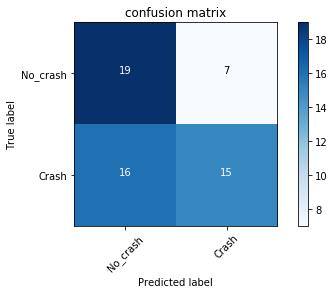

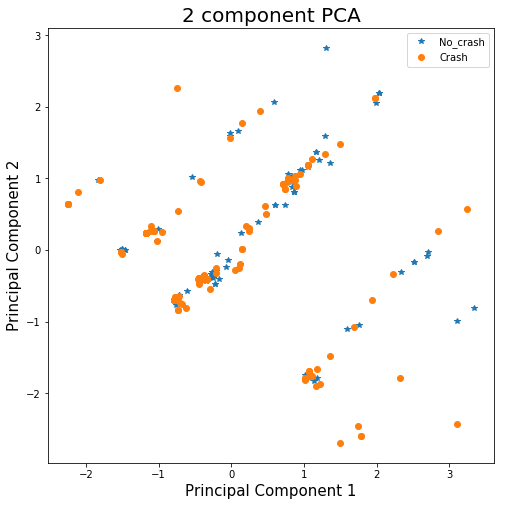

In [8]:
clf = LogisticRegression( penalty='l1')
Classifier_performance(clf, ["No_crash", "Crash"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

# Support Vector Machine Learning Model to predict crash and no crash risk

Training Accuracy Score:  0.6123348017621145
validation Accuracy Score: 0.49122807017543857
Classification Report: 
             precision    recall  f1-score   support

   No_crash       0.47      0.77      0.58        26
      Crash       0.57      0.26      0.36        31

avg / total       0.52      0.49      0.46        57

Confusion matrix, without normalization
[[20  6]
 [23  8]]


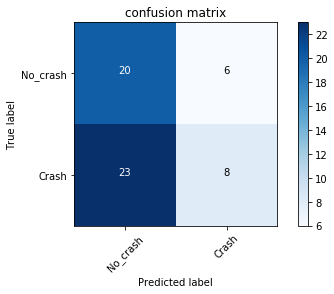

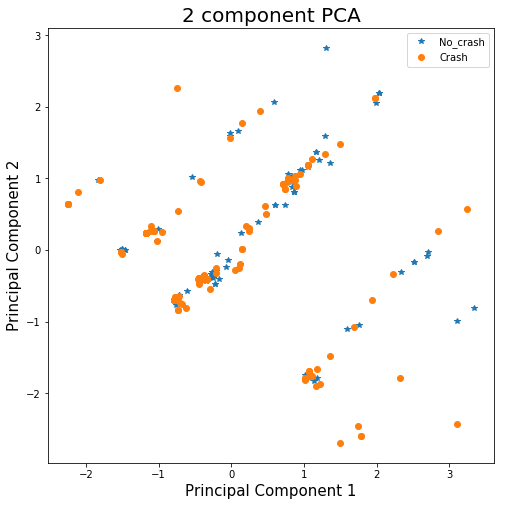

In [9]:
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[1, 5, 10, 0.5, 0.25, 0.125, 0.065], "degree":[3, 5, 7, 9, 15]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=3)
Classifier_performance(clf, ["No_crash", "Crash"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

In [10]:
clf.best_estimator_

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#  Random Forest Based Machine Learning Models


Training Accuracy Score:  0.7929515418502202
validation Accuracy Score: 0.5263157894736842
Classification Report: 
             precision    recall  f1-score   support

   No_crash       0.48      0.62      0.54        26
      Crash       0.58      0.45      0.51        31

avg / total       0.54      0.53      0.52        57

Confusion matrix, without normalization
[[16 10]
 [17 14]]


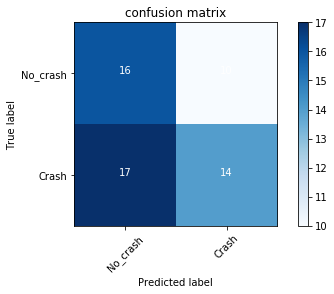

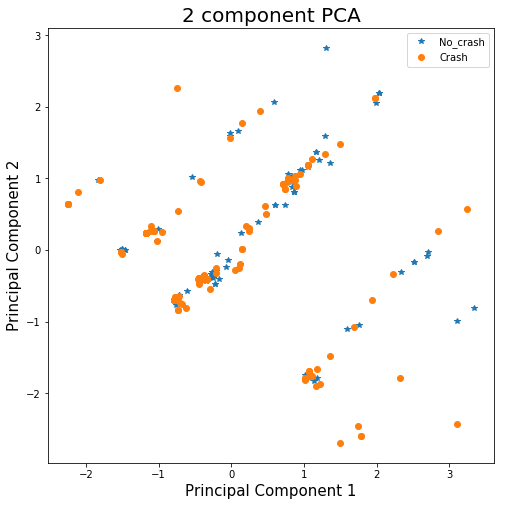

In [11]:
parameters = {"n_estimators":[1, 5, 10, 25, 50, 100, 250], "criterion":["gini", "entropy"], "max_depth":[5, 10, 26, 50, 100]}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, cv=7)
Classifier_performance(clf, ["No_crash", "Crash"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

In [12]:
est = sm.OLS(y, filledData.astype(float))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     15.58
Date:                Mon, 26 Nov 2018   Prob (F-statistic):           9.64e-29
Time:                        13:17:37   Log-Likelihood:                -217.76
No. Observations:                 284   AIC:                             465.5
Df Residuals:                     269   BIC:                             520.3
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
hear              0.1268      0.088      1.445

# Predicting Crash risk for including just crash and baseline condition. (Near crash not considered) using the vehicle profile from both young and old driver.

In [13]:
leftTurn = pd.read_excel("leftturn_new.xlsx")

# removing the near crash files.
leftTurn = leftTurn[leftTurn["crashStatus"] != 'Near-Crash'] 

data = leftTurn.drop(["File_id","time_of_entering","time_of_exiting","precipitatingEvent",
                      "preIncidentManeuver", "crash", "maneuverJudgment", "incomplete_video", 
                      "vehicle_movement", 'intersection_type'], axis = 1)


temp = data[['hear', 'heart', 'resp',
       'brain', 'vasc', 'nrvsandSlp', 'metab', 'limFlex', 'sevArthr', 'psych',
       'multMedConds', 'multMeds', 'dhiVisual', 'dhiFOV', 'clockDrawaing']]
temp.fillna(0, inplace = True)
temp = temp.replace("(null)", 0)
data[['hear', 'heart', 'resp',
       'brain', 'vasc', 'nrvsandSlp', 'metab', 'limFlex', 'sevArthr', 'psych',
       'multMedConds', 'multMeds', 'dhiVisual', 'dhiFOV', 'clockDrawaing']] = temp

filledData = data[['hear', 'heart', 'resp',
       'brain', 'vasc', 'nrvsandSlp', 'metab', 'limFlex', 'sevArthr', 'psych',
       'multMedConds', 'multMeds', 'dhiVisual', 'dhiFOV', 'clockDrawaing']] 

# Filling Qualtrics Varible with 1


y = data["crashStatus"]
data = data.drop( 'crashStatus', axis=1)
y[y=="Balanced-Sample Baseline"] = False
y[y != False] = True
y  = np.asarray(y,dtype=np.float64)

print("Number of crashs events: ", sum(y))
print("Class Balance with Crash and Baseline Condition: ", sum(y)/len(y))

selector = SelectKBest(f_classif, k=k).fit(filledData, y)
columns = filledData.columns[selector.get_support()]
filledData = filledData[np.array(columns)]

X_train, X_test, y_train, y_test = train_test_split(filledData, y, train_size=0.7, random_state=42)

Number of crashs events:  36.0
Class Balance with Crash and Baseline Condition:  0.20454545454545456


Training Accuracy Score:  0.7723577235772358
validation Accuracy Score: 0.8490566037735849
Classification Report: 
             precision    recall  f1-score   support

   No_crash       0.85      1.00      0.92        45
      Crash       0.00      0.00      0.00         8

avg / total       0.72      0.85      0.78        53

Confusion matrix, without normalization
[[45  0]
 [ 8  0]]


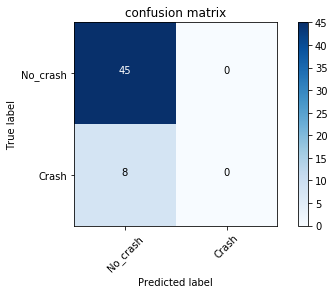

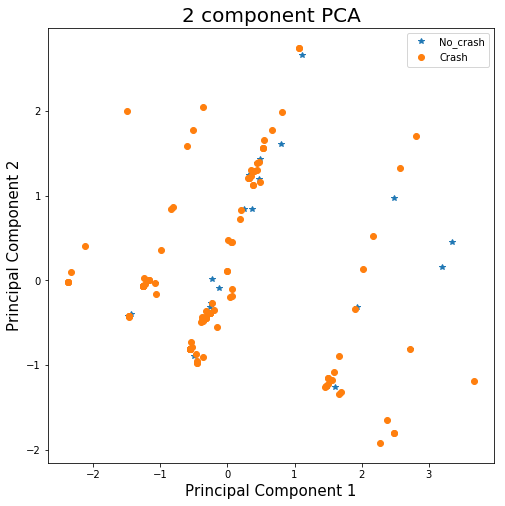

In [14]:
clf = LogisticRegression(max_iter=100, penalty='l1')
Classifier_performance(clf, ["No_crash", "Crash"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

# SVM Based model :
    Predicting Crash risk for including just crash and baseline condition. (Near crash not considered) using the vehicle profile from both young and old driver.

Training Accuracy Score:  0.7723577235772358
validation Accuracy Score: 0.8490566037735849
Classification Report: 
             precision    recall  f1-score   support

   No_crash       0.85      1.00      0.92        45
      Crash       0.00      0.00      0.00         8

avg / total       0.72      0.85      0.78        53

Confusion matrix, without normalization
[[45  0]
 [ 8  0]]


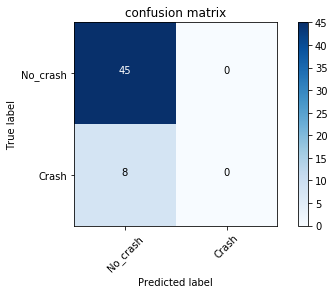

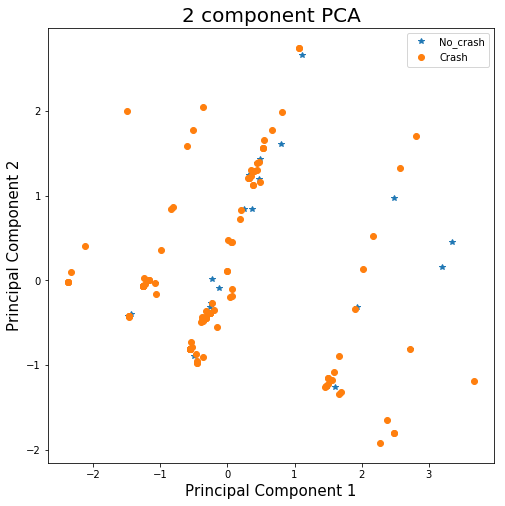

In [15]:
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[1, 5, 10, 0.5, 0.25, 0.125, 0.065], "degree":[3, 5, 7, 9, 15]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=3)
Classifier_performance(clf, ["No_crash", "Crash"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

# Random Forest Based Machine Learning Models¶:
    Predicting Crash risk for including just crash and baseline condition. (Near crash not considered) using the vehicle profile from both young and old driver.

Training Accuracy Score:  0.8048780487804879
validation Accuracy Score: 0.8490566037735849
Classification Report: 
             precision    recall  f1-score   support

   No_crash       0.88      0.96      0.91        45
      Crash       0.50      0.25      0.33         8

avg / total       0.82      0.85      0.83        53

Confusion matrix, without normalization
[[43  2]
 [ 6  2]]


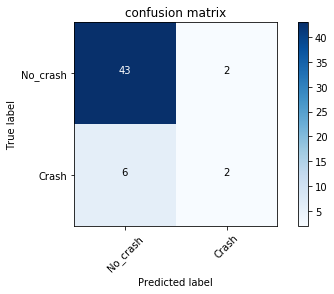

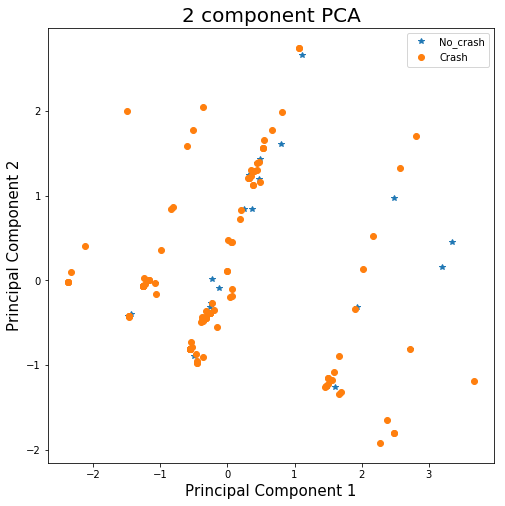

In [16]:
parameters = {"n_estimators":[1, 5, 10, 25, 50, 100, 250], "criterion":["gini", "entropy"], "max_depth":[5, 10, 26, 50, 100]}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, cv=7)
Classifier_performance(clf, ["No_crash", "Crash"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

In [17]:
est = sm.OLS(y, filledData.astype(float))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     5.068
Date:                Mon, 26 Nov 2018   Prob (F-statistic):           3.89e-08
Time:                        13:19:16   Log-Likelihood:                -76.046
No. Observations:                 176   AIC:                             182.1
Df Residuals:                     161   BIC:                             229.6
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
hear             -0.0007      0.087     -0.008

# Predicting if the driver is young or old from their driving data all 275 data used


In [18]:
leftTurn = pd.read_excel("leftturn_new.xlsx")
data = leftTurn.drop(["File_id","time_of_entering","time_of_exiting","precipitatingEvent",
                      "preIncidentManeuver", "crash", "maneuverJudgment", "incomplete_video", 
                      "vehicle_movement", 'intersection_type', "crashStatus", "age"], axis = 1)

# Filling empty value in the questionary variable with zero
temp = data[['hear', 'heart', 'resp',
       'brain', 'vasc', 'nrvsandSlp', 'metab', 'limFlex', 'sevArthr', 'psych',
       'multMedConds', 'multMeds', 'dhiVisual', 'dhiFOV', 'clockDrawaing']]
temp.fillna(0, inplace = True)
temp = temp.replace("(null)", 0)
data[['hear', 'heart', 'resp',
       'brain', 'vasc', 'nrvsandSlp', 'metab', 'limFlex', 'sevArthr', 'psych',
       'multMedConds', 'multMeds', 'dhiVisual', 'dhiFOV', 'clockDrawaing']] = temp

filledData = data[['hear', 'heart', 'resp',
       'brain', 'vasc', 'nrvsandSlp', 'metab', 'limFlex', 'sevArthr', 'psych',
       'multMedConds', 'multMeds', 'dhiVisual', 'dhiFOV', 'clockDrawaing']] 

y = leftTurn["age"]
y[y >= 65] = True
y[y != True] = False
y  = np.asarray(y,dtype=np.float64)
print("Number of old drivers: ", sum(y))
print("Class Balance with old drivers and young driver: ", sum(y)/len(y))

selector = SelectKBest(f_classif, k=k).fit(filledData, y)
columns = filledData.columns[selector.get_support()]
filledData = filledData[np.array(columns)]

X_train, X_test, y_train, y_test = train_test_split(filledData, y, train_size=0.7, random_state=42)

Number of old drivers:  175.0
Class Balance with old drivers and young driver:  0.6161971830985915


Training Accuracy Score:  0.7828282828282829
validation Accuracy Score: 0.6976744186046512
Classification Report: 
             precision    recall  f1-score   support

      Young       0.53      0.79      0.64        29
        Old       0.86      0.65      0.74        57

avg / total       0.75      0.70      0.71        86

Confusion matrix, without normalization
[[23  6]
 [20 37]]


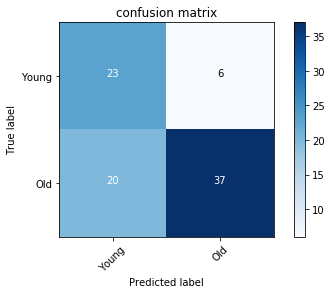

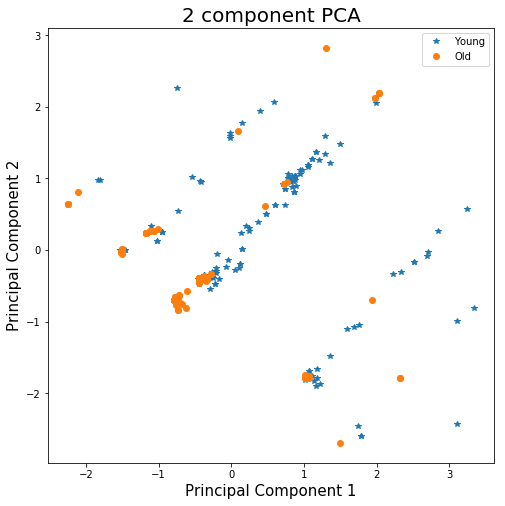

In [19]:
clf = LogisticRegression(max_iter=1000, penalty='l1')
Classifier_performance(clf, ["Young", "Old"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

# SVM Based model :
Predicting if the driver is young or old from their driving data all 275 data used¶

Training Accuracy Score:  0.8434343434343434
validation Accuracy Score: 0.7209302325581395
Classification Report: 
             precision    recall  f1-score   support

      Young       0.59      0.59      0.59        29
        Old       0.79      0.79      0.79        57

avg / total       0.72      0.72      0.72        86

Confusion matrix, without normalization
[[17 12]
 [12 45]]


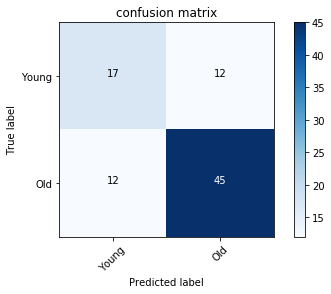

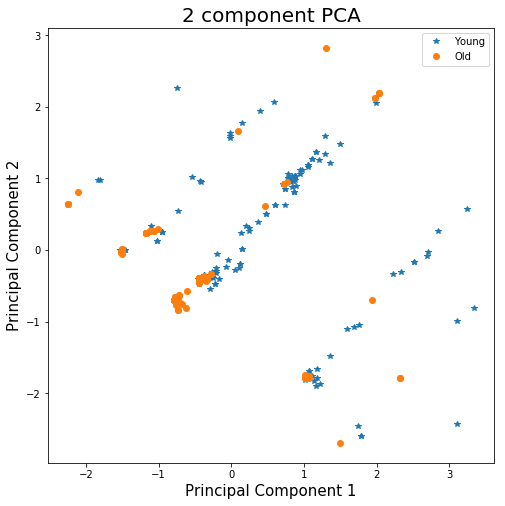

In [20]:
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[1, 5, 10, 0.5, 0.25, 0.125, 0.065], "degree":[3, 5, 7, 9, 15]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=3)
Classifier_performance(clf, ["Young", "Old"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

# Random Forest Based Machine Learning Models¶:
Predicting Crash risk for including just crash and baseline condition. (Near crash not considered) using the vehicle profile from both young and old driver.

Training Accuracy Score:  0.898989898989899
validation Accuracy Score: 0.6627906976744186
Classification Report: 
             precision    recall  f1-score   support

      Young       0.50      0.76      0.60        29
        Old       0.83      0.61      0.71        57

avg / total       0.72      0.66      0.67        86

Confusion matrix, without normalization
[[22  7]
 [22 35]]


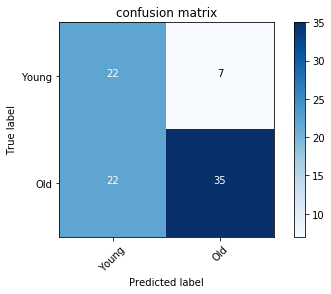

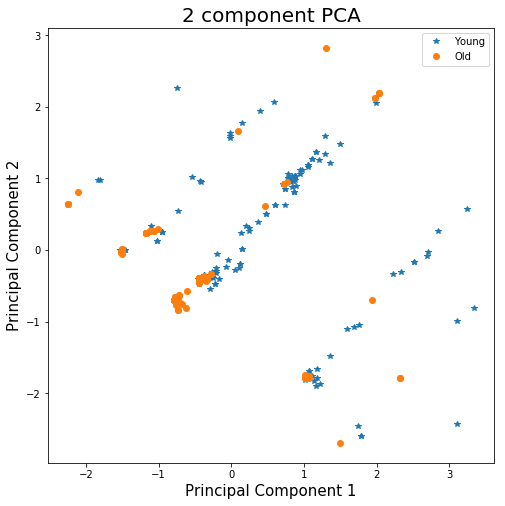

In [21]:
parameters = {"n_estimators":[1, 5, 10, 25, 50, 100, 250], "criterion":["gini", "entropy"], "max_depth":[5, 10, 26, 50, 100]}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, cv=7)
Classifier_performance(clf, ["Young", "Old"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

In [22]:
est = sm.OLS(y, filledData.astype(float))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     44.72
Date:                Mon, 26 Nov 2018   Prob (F-statistic):           4.20e-64
Time:                        13:20:53   Log-Likelihood:                -156.58
No. Observations:                 284   AIC:                             343.2
Df Residuals:                     269   BIC:                             397.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
hear              0.2721      0.071      3.846

# Model to predict old driver at risk of crash or not

In [23]:
leftTurn = pd.read_excel("leftturn_new.xlsx")

old_crash = leftTurn[(leftTurn["age"]>=65) & ((leftTurn["crashStatus"]=="Crash"))]
old_baseline = leftTurn[(leftTurn["age"]>=65) & (leftTurn["crashStatus"]=="Balanced-Sample Baseline")][:30]
leftTurn = pd.concat([old_crash, old_baseline])
data = leftTurn.drop(["File_id","time_of_entering","time_of_exiting","precipitatingEvent",
                      "preIncidentManeuver", "crash", "maneuverJudgment", "incomplete_video", 
                      "vehicle_movement", 'intersection_type'], axis = 1)

# Filling empty value in the questionary variable with zero
temp = data[['hear', 'heart', 'resp',
       'brain', 'vasc', 'nrvsandSlp', 'metab', 'limFlex', 'sevArthr', 'psych',
       'multMedConds', 'multMeds', 'dhiVisual', 'dhiFOV', 'clockDrawaing']]

temp.fillna(0, inplace = True)

temp = temp.replace("(null)", 0)

data[['hear', 'heart', 'resp',
       'brain', 'vasc', 'nrvsandSlp', 'metab', 'limFlex', 'sevArthr', 'psych',
       'multMedConds', 'multMeds', 'dhiVisual', 'dhiFOV', 'clockDrawaing']] = temp

filledData = data[['hear', 'heart', 'resp',
       'brain', 'vasc', 'nrvsandSlp', 'metab', 'limFlex', 'sevArthr', 'psych',
       'multMedConds', 'multMeds', 'dhiVisual', 'dhiFOV', 'clockDrawaing']] 



y = data["crashStatus"]
data = data.drop( 'crashStatus', axis=1)
y[y=="Balanced-Sample Baseline"] = False
y[y != False] = True
y  = np.asarray(y,dtype=np.float64)


print("Number of crashs events: ", sum(y))
print("Class Balance with Crash and Baseline Condition: ", sum(y)/len(y))
# from sklearn.feature_selection import SelectKBest,f_classif
# selector = SelectKBest(f_classif, k=10).fit(filledData,y)
# featurefilledData = selector.transform(filledData)

selector = SelectKBest(f_classif, k=k).fit(filledData, y)
columns = filledData.columns[selector.get_support()]
filledData = filledData[np.array(columns)]

X_train, X_test, y_train, y_test = train_test_split(filledData, y, train_size=0.7, random_state=42)

Number of crashs events:  24.0
Class Balance with Crash and Baseline Condition:  0.4444444444444444


Training Accuracy Score:  0.7837837837837838
validation Accuracy Score: 0.47058823529411764
Classification Report: 
                        precision    recall  f1-score   support

Old driver not at risk       0.46      0.75      0.57         8
   Old drivers at risk       0.50      0.22      0.31         9

           avg / total       0.48      0.47      0.43        17

Confusion matrix, without normalization
[[6 2]
 [7 2]]


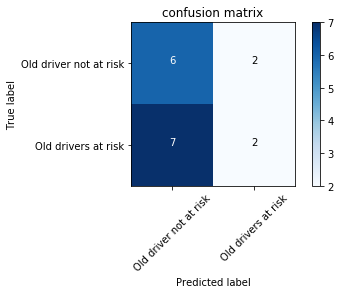

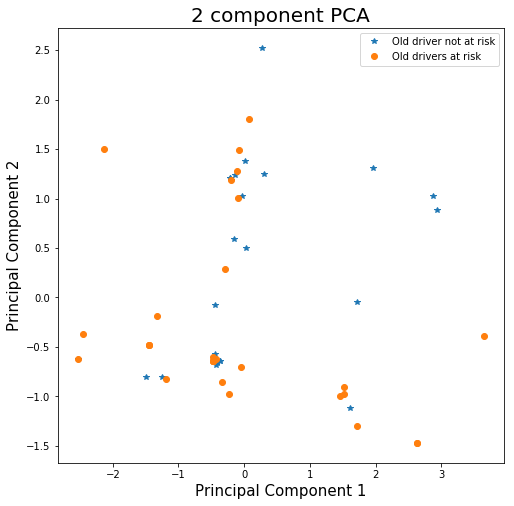

In [24]:
clf = LogisticRegression(max_iter=100, penalty='l1')
Classifier_performance(clf, ["Old driver not at risk", "Old drivers at risk"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

# SVM Based model to predict old driver at risk of crash or not:

Training Accuracy Score:  0.918918918918919
validation Accuracy Score: 0.7058823529411765
Classification Report: 
                        precision    recall  f1-score   support

Old driver not at risk       0.64      0.88      0.74         8
   Old drivers at risk       0.83      0.56      0.67         9

           avg / total       0.74      0.71      0.70        17

Confusion matrix, without normalization
[[7 1]
 [4 5]]


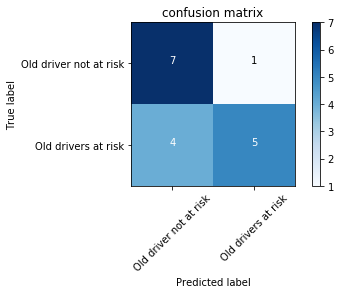

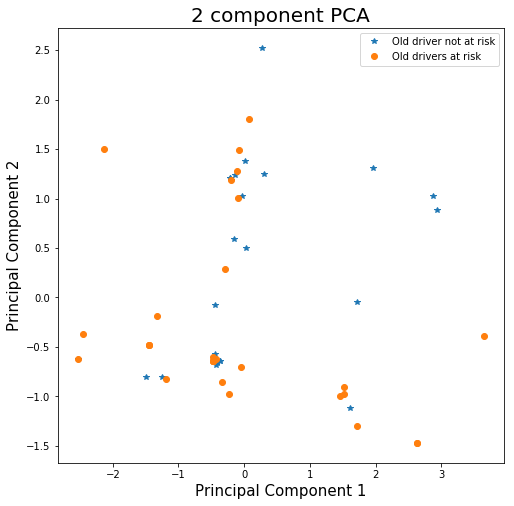

In [25]:
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[1, 5, 10, 0.5, 0.25, 0.125, 0.065], "degree":[3, 5, 7, 9, 15]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=3)
Classifier_performance(clf, ["Old driver not at risk", "Old drivers at risk"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

# Random Forest Based Machine Learning Models¶:
    predict old driver at risk of crash or not:


Training Accuracy Score:  0.918918918918919
validation Accuracy Score: 0.7647058823529411
Classification Report: 
                        precision    recall  f1-score   support

Old driver not at risk       0.70      0.88      0.78         8
   Old drivers at risk       0.86      0.67      0.75         9

           avg / total       0.78      0.76      0.76        17

Confusion matrix, without normalization
[[7 1]
 [3 6]]


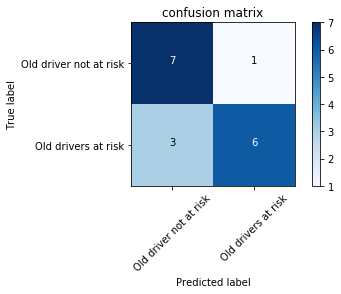

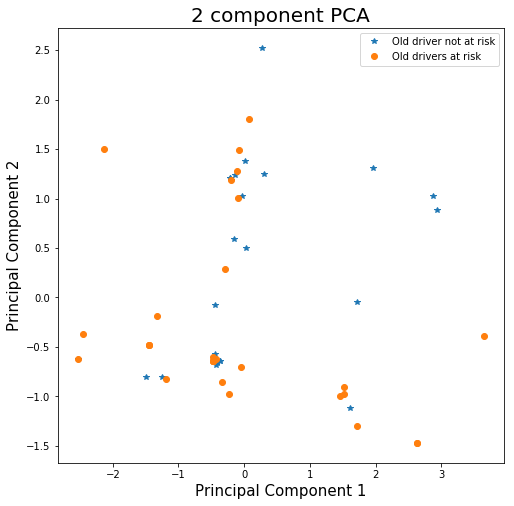

In [26]:
parameters = {"n_estimators":[1, 5, 10, 25, 50, 100, 250], "criterion":["gini", "entropy"], "max_depth":[5, 10, 26, 50, 100]}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, cv=7)
Classifier_performance(clf, ["Old driver not at risk", "Old drivers at risk"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

In [27]:
est = sm.OLS(y, filledData.astype(float))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     7.756
Date:                Mon, 26 Nov 2018   Prob (F-statistic):           1.34e-07
Time:                        13:22:28   Log-Likelihood:                -17.412
No. Observations:                  54   AIC:                             64.82
Df Residuals:                      39   BIC:                             94.66
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
hear              0.1361      0.175      0.778

# drivers 65 or less at the crash risk or not

In [28]:
leftTurn = pd.read_excel("leftturn_new.xlsx")

young_crash = leftTurn[(leftTurn["age"]<=65) & ((leftTurn["crashStatus"]=="Crash"))]
young_baseline = leftTurn[(leftTurn["age"]<=65) & (leftTurn["crashStatus"]=="Balanced-Sample Baseline")][:20]
leftTurn = pd.concat([young_crash, young_baseline])
data = leftTurn.drop(["File_id","time_of_entering","time_of_exiting","precipitatingEvent",
                      "preIncidentManeuver", "crash", "maneuverJudgment", "incomplete_video", 
                      "vehicle_movement", 'intersection_type'], axis = 1)

# Filling empty value in the questionary variable with zero
temp = data[['hear', 'heart', 'resp',
       'brain', 'vasc', 'nrvsandSlp', 'metab', 'limFlex', 'sevArthr', 'psych',
       'multMedConds', 'multMeds', 'dhiVisual', 'dhiFOV', 'clockDrawaing']]

temp.fillna(0, inplace = True)

temp = temp.replace("(null)", 0)

data[['hear', 'heart', 'resp',
       'brain', 'vasc', 'nrvsandSlp', 'metab', 'limFlex', 'sevArthr', 'psych',
       'multMedConds', 'multMeds', 'dhiVisual', 'dhiFOV', 'clockDrawaing']] = temp

filledData = data[['hear', 'heart', 'resp',
       'brain', 'vasc', 'nrvsandSlp', 'metab', 'limFlex', 'sevArthr', 'psych',
       'multMedConds', 'multMeds', 'dhiVisual', 'dhiFOV', 'clockDrawaing']] 

# Filling Qualtrics Varible with 1
y = data["crashStatus"]
data = data.drop( 'crashStatus', axis=1)
y[y=="Balanced-Sample Baseline"] = False
y[y != False] = True
y  = np.asarray(y,dtype=np.float64)


print("Number of crashs events: ", sum(y))
print("Class Balance with Crash and Baseline Condition: ", sum(y)/len(y))

selector = SelectKBest(f_classif, k=k).fit(filledData, y)
columns = filledData.columns[selector.get_support()]
filledData = filledData[np.array(columns)]

X_train, X_test, y_train, y_test = train_test_split(filledData, y, train_size=0.7, random_state=42)

Number of crashs events:  10.0
Class Balance with Crash and Baseline Condition:  0.3333333333333333


Training Accuracy Score:  0.6666666666666666
validation Accuracy Score: 0.7777777777777778
Classification Report: 
                        precision    recall  f1-score   support

Old driver not at risk       0.78      1.00      0.88         7
   Old drivers at risk       0.00      0.00      0.00         2

           avg / total       0.60      0.78      0.68         9

Confusion matrix, without normalization
[[7 0]
 [2 0]]


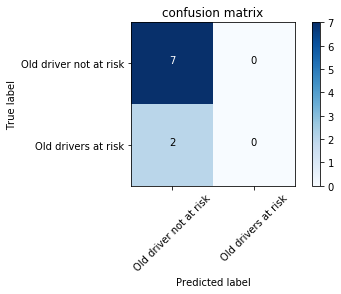

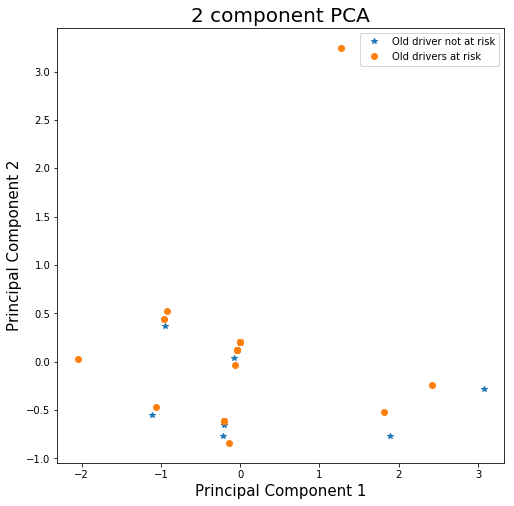

In [29]:
clf = LogisticRegression(max_iter=100, penalty='l1')
Classifier_performance(clf, ["Old driver not at risk", "Old drivers at risk"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

# SVM Based model to predict drivers 65 or less at the crash risk or not¶


Training Accuracy Score:  0.8571428571428571
validation Accuracy Score: 0.6666666666666666
Classification Report: 
                        precision    recall  f1-score   support

Old driver not at risk       0.75      0.86      0.80         7
   Old drivers at risk       0.00      0.00      0.00         2

           avg / total       0.58      0.67      0.62         9

Confusion matrix, without normalization
[[6 1]
 [2 0]]


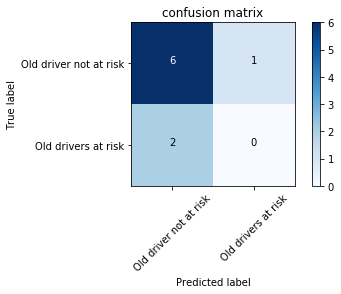

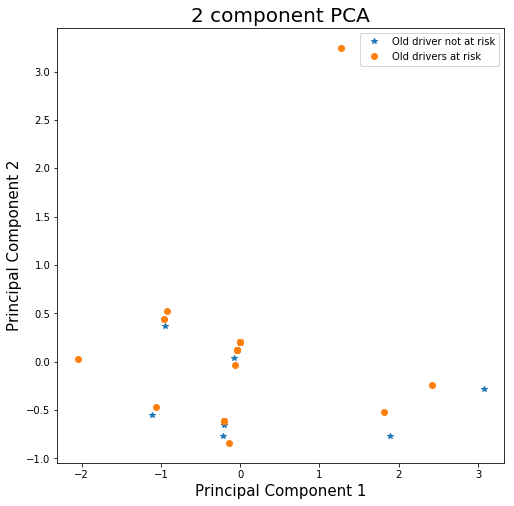

In [30]:
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[1, 5, 10, 0.5, 0.25, 0.125, 0.065], "degree":[3, 5, 7, 9, 15]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=3)
Classifier_performance(clf, ["Old driver not at risk", "Old drivers at risk"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

# Random Forest Based Machine Learning Models¶:
drivers 65 or less at the crash risk or not¶¶

Training Accuracy Score:  0.8095238095238095
validation Accuracy Score: 0.6666666666666666
Classification Report: 
                        precision    recall  f1-score   support

Old driver not at risk       0.75      0.86      0.80         7
   Old drivers at risk       0.00      0.00      0.00         2

           avg / total       0.58      0.67      0.62         9

Confusion matrix, without normalization
[[6 1]
 [2 0]]


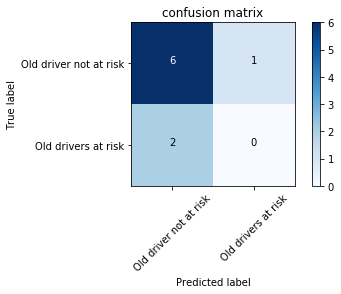

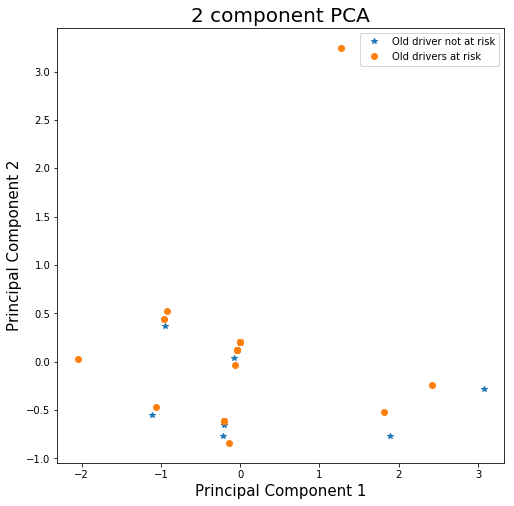

In [31]:
parameters = {"n_estimators":[1, 5, 10, 25, 50, 100, 250], "criterion":["gini", "entropy"], "max_depth":[5, 10, 26, 50, 100]}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, cv=7)
Classifier_performance(clf, ["Old driver not at risk", "Old drivers at risk"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

In [32]:
est = sm.OLS(y, filledData.astype(float))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     2.751
Date:                Mon, 26 Nov 2018   Prob (F-statistic):             0.0269
Time:                        13:23:39   Log-Likelihood:                -14.407
No. Observations:                  30   AIC:                             46.81
Df Residuals:                      21   BIC:                             59.42
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
hear             -0.3818      0.538     -0.710